# Predicting Bike Rentals in Seoul

Download necessay dependencies (if running on desktop instead of Google Colab)

In [1]:
%pip install seaborn
%pip install numpy
%pip install pandas
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Import the necessary dependencies

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import shapiro

### Importing the Data

In [3]:
bike_data = pd.read_csv('./data/SeoulBikeData.csv', encoding='unicode_escape')
bike_data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Data Exploration

Number of Observation and Features

In [4]:
bike_data.shape

(8760, 14)

=> we have 8760 observations with 14 features each.

Next, let's take a look at the data types for each feature

In [5]:
bike_data.dtypes

Date                          object
Rented Bike Count              int64
Hour                           int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object

We see that most are already in a number format (int64 or float64) which is convenient.
However, we will have to deal with encoding those provided as objects, namely Date, Season, Holiday and Functioning Day.

Plot of Data Distribution

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

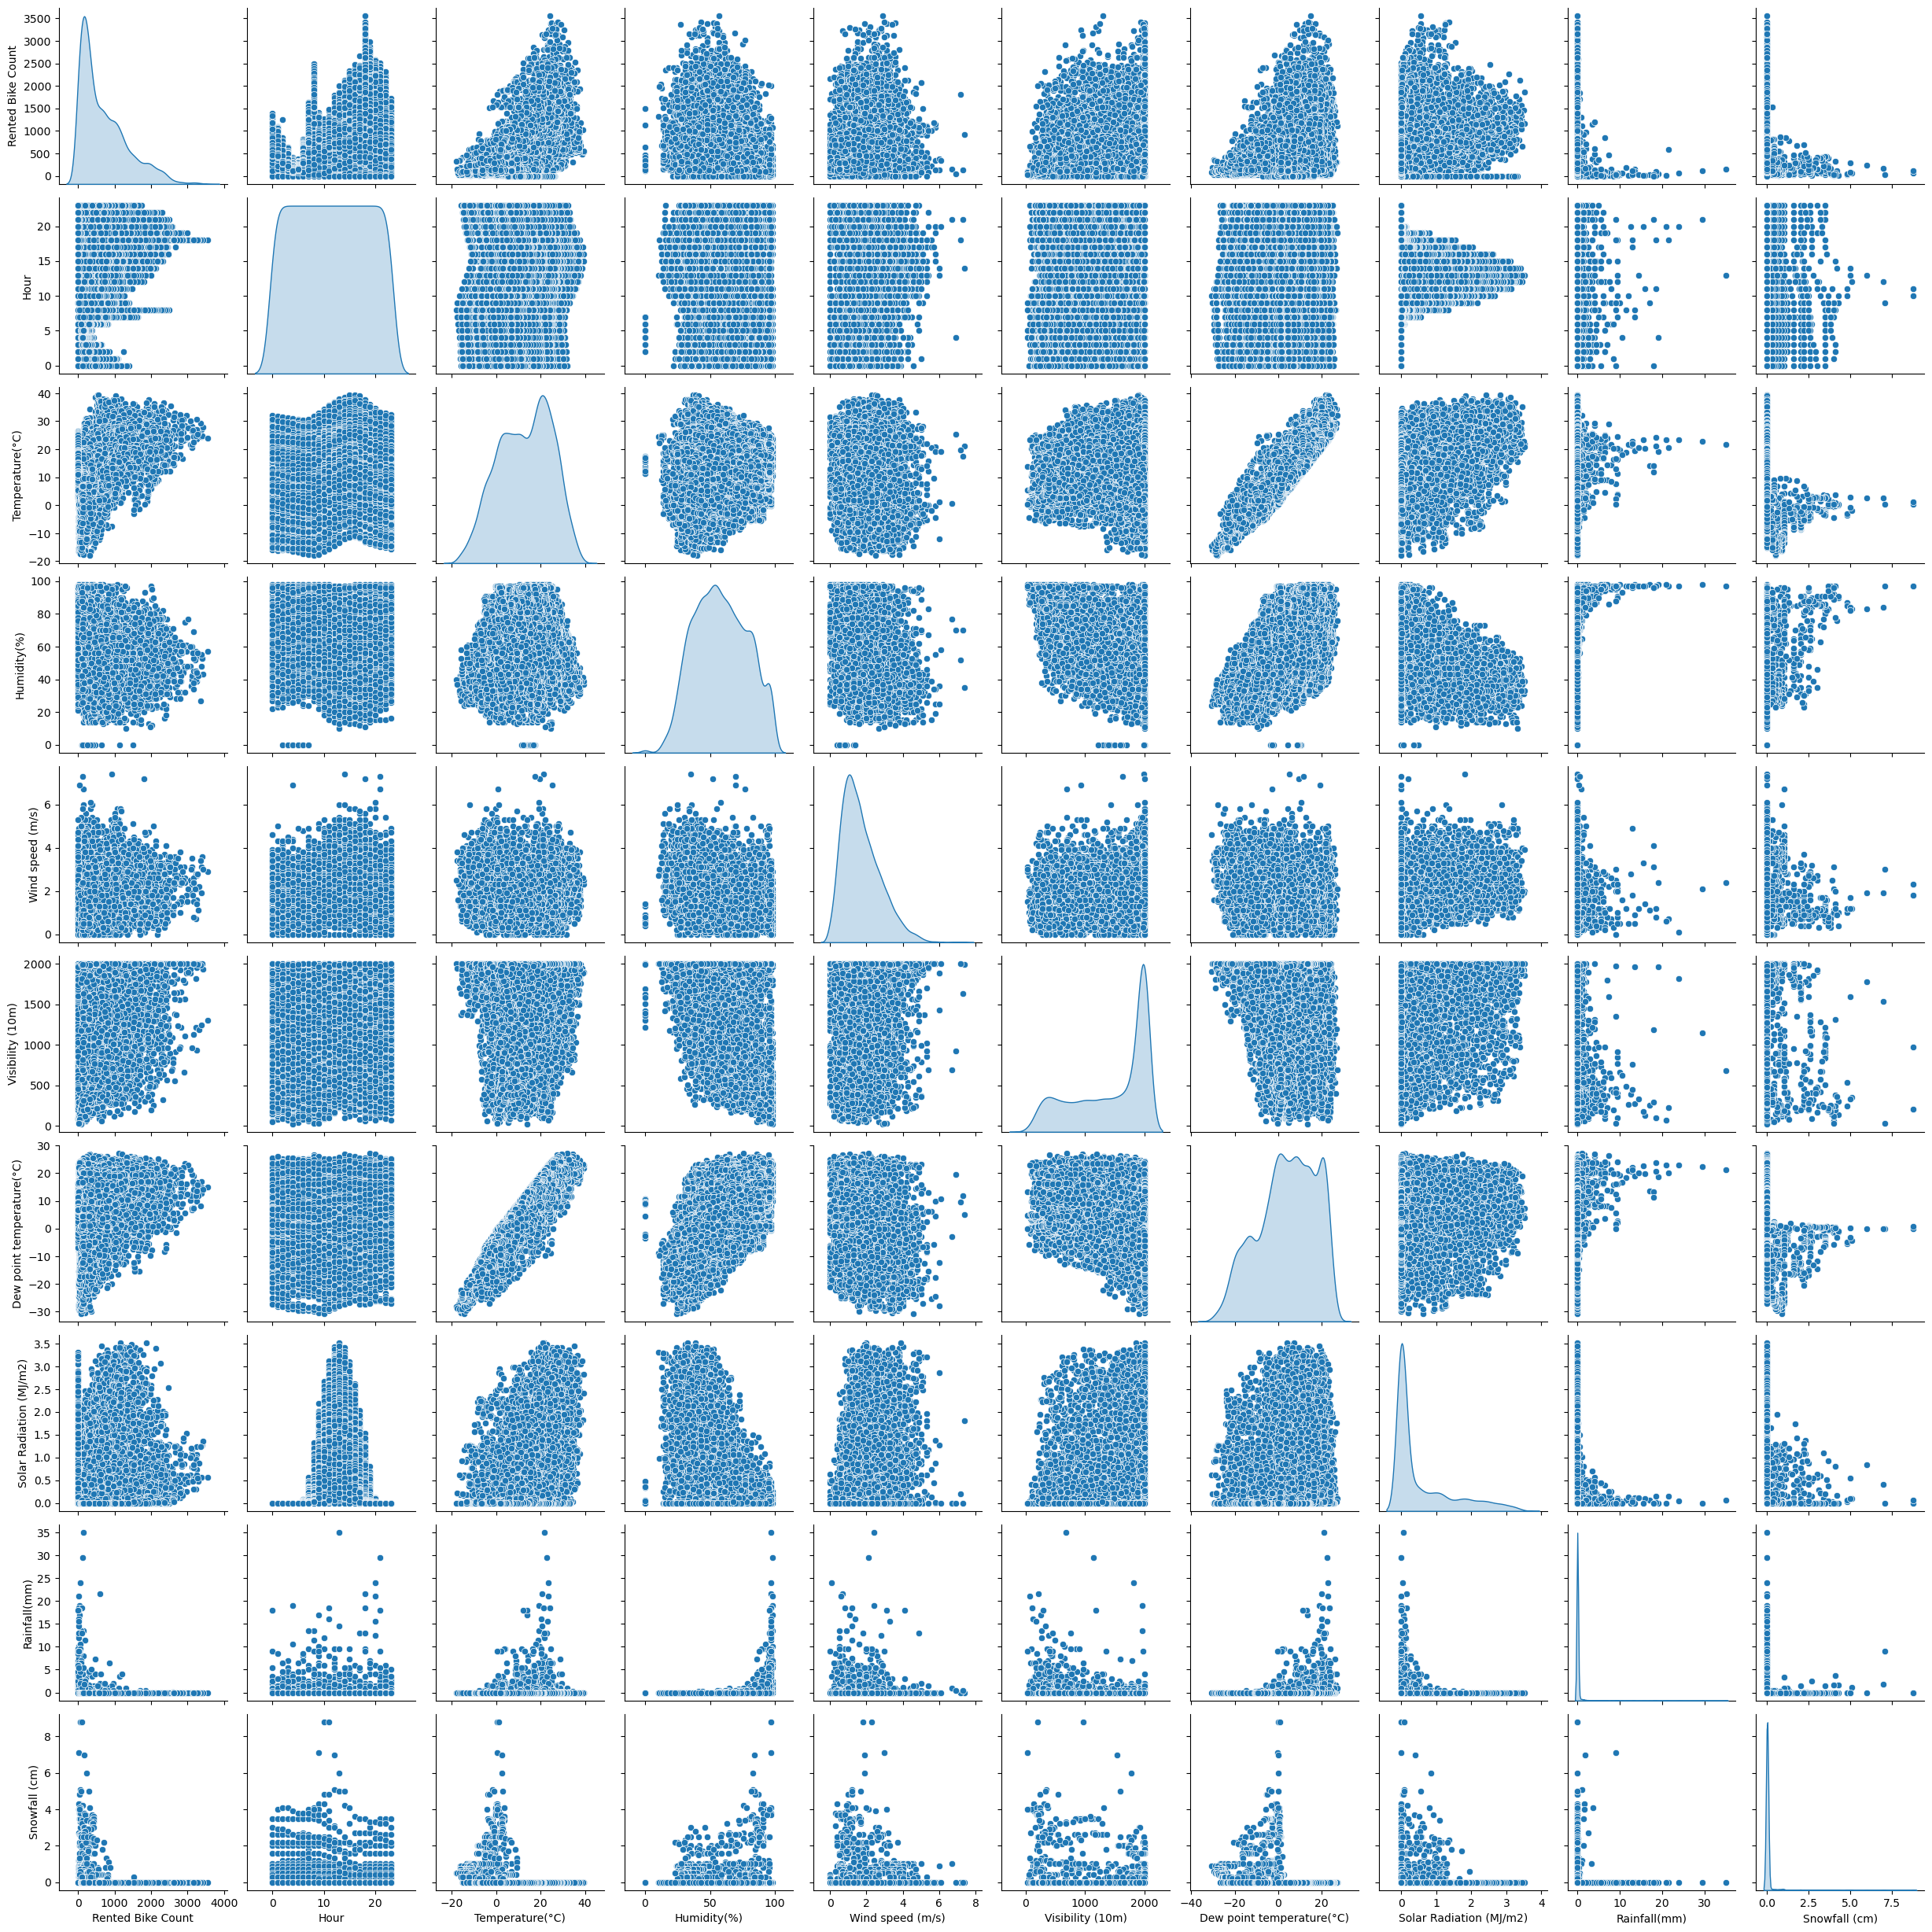

In [6]:
pair_plot = sns.pairplot(bike_data, diag_kind='kde')

The pairplot gives us a first impression of our data. We don't see any outliers that would require attention. On the first glance it seems like rainfall is a very good indicator for the number of rented bikes. Hour and rainfall seem to be useful as well.

Data Description

In [7]:
bike_data.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


All min and max values seem to be in a realistic range.

Checking for Missing Data

In [8]:
bike_data.isnull().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

As there is no data missing, we don't have to pre-process NA values.

Checking Unique Data

In [9]:
for col in bike_data.columns:
    print(col, bike_data[col].unique())

Date ['01/12/2017' '02/12/2017' '03/12/2017' '04/12/2017' '05/12/2017'
 '06/12/2017' '07/12/2017' '08/12/2017' '09/12/2017' '10/12/2017'
 '11/12/2017' '12/12/2017' '13/12/2017' '14/12/2017' '15/12/2017'
 '16/12/2017' '17/12/2017' '18/12/2017' '19/12/2017' '20/12/2017'
 '21/12/2017' '22/12/2017' '23/12/2017' '24/12/2017' '25/12/2017'
 '26/12/2017' '27/12/2017' '28/12/2017' '29/12/2017' '30/12/2017'
 '31/12/2017' '01/01/2018' '02/01/2018' '03/01/2018' '04/01/2018'
 '05/01/2018' '06/01/2018' '07/01/2018' '08/01/2018' '09/01/2018'
 '10/01/2018' '11/01/2018' '12/01/2018' '13/01/2018' '14/01/2018'
 '15/01/2018' '16/01/2018' '17/01/2018' '18/01/2018' '19/01/2018'
 '20/01/2018' '21/01/2018' '22/01/2018' '23/01/2018' '24/01/2018'
 '25/01/2018' '26/01/2018' '27/01/2018' '28/01/2018' '29/01/2018'
 '30/01/2018' '31/01/2018' '01/02/2018' '02/02/2018' '03/02/2018'
 '04/02/2018' '05/02/2018' '06/02/2018' '07/02/2018' '08/02/2018'
 '09/02/2018' '10/02/2018' '11/02/2018' '12/02/2018' '13/02/2018'
 '14/

The unique data gives a good impression of the range.
Following that the date is continuos from 12/2017 to 11/2018, encoding dates as day of the year or numbers of ints starting from the first date seems reasonable.
For season (currently in string-format) we plan to apply label encoding on a scale from 0 to 3 for the four different seasons.
Holiday as well as Functioning Day are essentially boolean data, thus we will convert them using label encoding.  

Plotting Heatmap

Text(0.5, 1.0, 'Correlation Matrix')

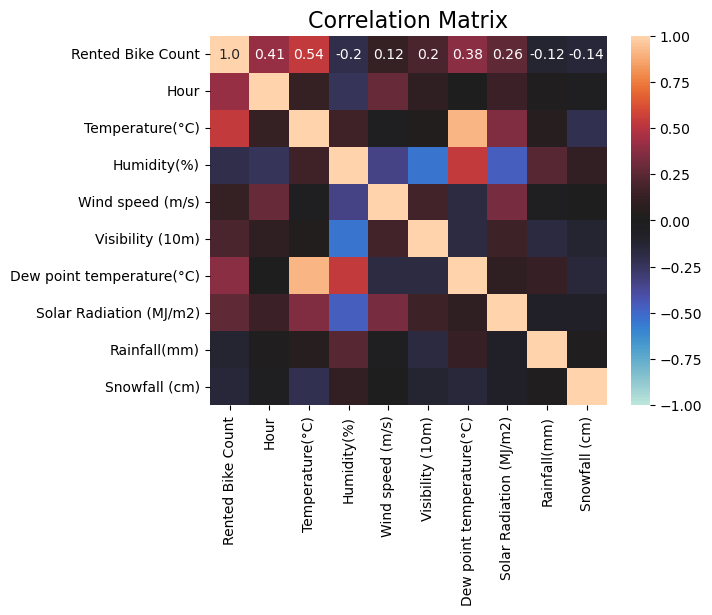

In [10]:
heat_map = sns.heatmap((bike_data.drop(columns=["Seasons", "Holiday", "Functioning Day", "Date"])).corr(), annot = True, fmt='.2', vmin=-1, vmax=1, center= 0)
heat_map.set_title("Correlation Matrix", fontsize=16)

Due to the fact that normalization is yet to be done, we should not fully rely on the output of our correlation in the heatmap. From the current correlation matrix, Temperature, Hour and Dew point temperature show some of the highest correlation to Rented Bike Count. Therefore, we believe those features to be good indicators of Rented Bike Count.

## Data Preprocessing

### Encoding our features
As discussed before, Seasons, Holidy, Functioning Day, and Date are string objects in our original dataset. Therefore, we need to encode or convert those features to make them easier to work with.

We first convert the string for Date to a date-time format. Then, we convert the date-time format into day of year.

In [11]:
print("Before ", bike_data['Date'])

bike_data['Date_Converted'] = pd.to_datetime(bike_data['Date'], format='%d/%m/%Y')
bike_data['Day_of_Year'] = bike_data['Date_Converted'].dt.dayofyear

print("After ", bike_data['Day_of_Year'])
print("After ", bike_data['Date_Converted'])

Before  0       01/12/2017
1       01/12/2017
2       01/12/2017
3       01/12/2017
4       01/12/2017
           ...    
8755    30/11/2018
8756    30/11/2018
8757    30/11/2018
8758    30/11/2018
8759    30/11/2018
Name: Date, Length: 8760, dtype: object
After  0       335
1       335
2       335
3       335
4       335
       ... 
8755    334
8756    334
8757    334
8758    334
8759    334
Name: Day_of_Year, Length: 8760, dtype: int32
After  0      2017-12-01
1      2017-12-01
2      2017-12-01
3      2017-12-01
4      2017-12-01
          ...    
8755   2018-11-30
8756   2018-11-30
8757   2018-11-30
8758   2018-11-30
8759   2018-11-30
Name: Date_Converted, Length: 8760, dtype: datetime64[ns]


After we converted our date column, we replaced them with Date_Converted and Day_of_Year. We then proceeded to drop the original Date and Date_Converted columns since we no longer have any uses for them.

In [12]:
bike_data.drop(columns=["Date", "Date_Converted"], inplace=True)
bike_data.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Day_of_Year
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,335
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,335
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,335
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,335
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,335


Next, we use label encoding to convert the Seasons feature into numerical labels

In [13]:
from sklearn.preprocessing import LabelEncoder
myle = LabelEncoder()

print("Before ", bike_data['Seasons'].unique())
bike_data['Seasons'] = myle.fit_transform(bike_data['Seasons'])
print("After ", bike_data['Seasons'].unique())

Before  ['Winter' 'Spring' 'Summer' 'Autumn']
After  [3 1 2 0]


It is important to note that the order that the label encoding is done may not correlate with the order of seasons. For example, 0 may not map to spring and 1 may not map to summer.

We also have to convert Functioning Day and Holiday into numerical numbers. Luckily, Functioning Day and Holiday each only have two types of values, "Yes" and "No" for Functionig Day and "Holiday" and "No Holiday" for Holiday. We simply have to maps these values to binary values.

In [14]:
# Functioning Day
bike_data['Functioning Day'] = bike_data['Functioning Day'].map({'Yes': 1, 'No': 0})
bike_data['Holiday'] = bike_data['Holiday'].map({'Holiday': 1, 'No Holiday': 0})

Finally, let's take a look at our pre-processed data

In [15]:
bike_data.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Day_of_Year
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,0,1,335
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,0,1,335
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,0,1,335
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,0,1,335
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,0,1,335


Export our pre-processed data into a new csv

In [16]:
# Export the data to a new CSV file
bike_data.to_csv('./data/SeoulBikeData_Processed.csv', index=False)